<a href="https://colab.research.google.com/github/Sassotek/Mechanistic-Interpretability-for-Vision-Models-Optimization/blob/main/Mechanistic_Interpretability_for_Vision_Models_Optimization_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notes

In [ ]:
!swd

/bin/bash: line 1: swd: command not found


##########Dataset Description
File descriptions

    train.images.zip - the training set (images distributed into class labeled folders)
    test.zip
   
    wnids.txt - list of the used ids from the original full set of ImageNet
    words.txt - description of all ids of ImageNet


+++++ https://www.kaggle.com/datasets/wissamsalam/tiny-imagenet-cleaned-for-classification


https://viso.ai/deep-learning/vision-transformer-vit/

https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch

https://docs.pytorch.org/vision/main/models/vision_transformer.html

https://github.com/lucidrains/vit-pytorch

https://arxiv.org/pdf/2010.11929.pdf

https://www.youtube.com/watch?v=j3VNqtJUoz0

https://www.youtube.com/watch?v=vJF3TBI8esQ

https://www.youtube.com/watch?v=nZ22Ecg9XCQ


** Dataset link sbagliato**
https://www.kaggle.com/c/tiny-imagenet


Gradient Plot
https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/37

#####GuidaEinops

https://nbviewer.org/github/arogozhnikov/einops/blob/main/docs/1-einops-basics.ipynb


**latent_size** (o anche detto embedding_dim, hidden_dim, ecc.) è la dimensione del vettore che rappresenta ogni patch dopo la proiezione lineare, ovvero la dimensione dello spazio latente in cui il modello "lavora".

**class token** per ogni batch, un vettore speciale che sarà usato dal ViT per l'output della classificazione.

**positional embedding** iniziale. Verrà poi ripetuta per il numero di patch + 1 (per il class token). Serve a dare informazioni sulla posizione dei patch nel Transformer.

**patches = einops.rearrange**(
    input,
    'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
    p1=self.patch_size, p2=self.patch_size
)*
Usa Einops per dividere ogni immagine in patch:

    Input: (b, c, H, W)

    Output: (b, N_patch, patch_dim), dove:

        N_patch = (H // patch_size) * (W // patch_size)

        patch_dim = patch_size * patch_size * c

Esempio: immagine 64x64, patch_size=16 → 16 patch da 16x16x3

In [ ]:
#save_path_model= ................./ciao.pth
#save_path_opt= ..../ott.pth

# Running Settings

In [ ]:
Pi_gpu=0


#Imports

In [12]:
import math
import matplotlib
import matplotlib.pyplot as plt
plt.ion()
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
from matplotlib.patches import FancyArrowPatch
import numpy as np
from PIL import Image
import cv2
from skimage import io, color
from collections import Counter


#Kaggle
!pip install kagglehub --quiet
import kagglehub


#PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ModuleList
from torch.utils.data import Dataset,DataLoader, SubsetRandomSampler, ConcatDataset
import torchvision
from torchvision import transforms,datasets
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF
from torchsummary import summary
import torch.optim as optim


import random
import os
import pandas as pd
from tqdm.notebook import tqdm
import time
import seaborn as sns
import einops
import sys
import requests
import urllib.request
from io import BytesIO
from prettytable import PrettyTable
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift


from IPython.display import display, Markdown, clear_output
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider, Dropdown, Output


import sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from timm.layers import DropPath
from timm.data.mixup import Mixup
from timm.loss.cross_entropy import SoftTargetCrossEntropy
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from torch.cuda.amp import GradScaler, autocast


# Setting the seed
torch.manual_seed(240700)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("Device",device)
if torch.cuda.is_available():
   torch.cuda.manual_seed(240700)
   torch.cuda.manual_seed_all(240700)

#ensure that all operations are deterministic on GPU if used,for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device cuda


In [13]:
device_list = ["NVIDIA GeForce RTX 3070", ""]

def hardware_check():
    # Check if GPU is available and return the device
    if torch.cuda.is_available():
        device = torch.device("cuda")
        device_name = torch.cuda.get_device_name()
        print(f"GPU is available!")
        print(f"  -> GPU - {torch.cuda.get_device_name()}")
        #print(f"  -> Total Memory: {torch.cuda.get_device_properties().total_memory / 1024**3:.2f} GB")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU.")
        print("\nCPU Information:")

        # Fix the backslash issue in the command string by escaping it
        cpu_model = os.popen("cat /proc/cpuinfo | grep \"model name\" | uniq").read().strip()
        print(f"CPU Model: {cpu_model}")
        print(f"Number of CPU cores: {os.cpu_count()}")

    return device, device_name

device, device_name = hardware_check()
print(f"\nUsing {device} for computation")


## Google Drive settings, only if is not local runtime
if device_name not in device_list:
  from google.colab.patches import cv2_imshow
  from google.colab import drive
  drive.mount('/content/drive')


GPU is available!
  -> GPU - Tesla T4

Using cuda for computation
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import nbformat
from pathlib import Path

def fix_widgets_metadata(path: Path):
    nb = nbformat.read(path, as_version=4)
    # Se c’è una sezione globale widgets, assicuriamoci che ogni entry abbia 'state'
    widgets = nb.metadata.get("widgets", {})
    for name, meta in widgets.items():
        meta.setdefault("state", {})
    if widgets:
        nb.metadata["widgets"] = widgets

    # Stessa cosa per ogni cella
    for cell in nb.cells:
        widgets = cell.metadata.get("widgets", {})
        for name, meta in widgets.items():
            meta.setdefault("state", {})
        if widgets:
            cell.metadata["widgets"] = widgets

    nbformat.write(nb, path)



# Globals

In [15]:
directory_drive="/content/drive/File_projects_CV"
directory_saved_models_drive="/content/drive/MyDrive//File_projects_CV/"
directory_saved_optimizers_drive="/content/drive/MyDrive//File_projects_CV/"
notebook_path= Path("/content/drive/MyDrive/File_projects_CV/Mechanistic_Interpretability_for_Vision_Models_Optimization_code.ipynb")

path_saves_pc_pi = "/home/user/work/Saved_Models/"
local_path = "/home/user/work/tiny-imagenet-200"

RED = "\033[31m"
GREEN = "\033[32m"
BLUE = "\033[34m"
RESET = "\033[0m"
CYAN="\033[36m"
MAGENTA="\033[35m"

#Transformer hyperparameters
patch_size = 16
latent_size = 768
#latent_size = 384
n_channels = 3
n_heads = 12
#n_heads = 6
n_encoders = 12
#n_encoders = 6
dropout = 0.1
n_classes = 200 #According to tinyimagenet
image_size = 64 #According to tinyimagenet

#Training
batch_size = 128
threshold = 10e-3
weight_decay = 0.01
label_smoothing = 0.1
learning_rate = 1e-4

# ImageNet mean and std
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

#Data

##Dataset Loading

In [ ]:
#data_path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")
if device_name in device_list:
  data_path = local_path
else:
  data_path= kagglehub.dataset_download("wissamsalam/tiny-imagenet-cleaned-for-classification")
  data_path= data_path+'/tiny-imagenet-200/'
  print("Path to dataset files:", data_path)

100%|██████████| 214M/214M [00:11<00:00, 19.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/wissamsalam/tiny-imagenet-cleaned-for-classification/versions/1/tiny-imagenet-200/


In [ ]:
def print_dataset_structure(root_dir, max_classes=3, max_images=3):
    print(f"📁 Directory: {root_dir}\n")

    class_dirs_all = []
    root_items = sorted(os.listdir(root_dir))
    for item in root_items:
        item_path = os.path.join(root_dir, item)

        if os.path.isfile(item_path):
            print(f"📄 {item}")

        elif os.path.isdir(item_path) and item in ['train', 'val', 'test']:
            print(f"\n📂 {item}/")

            class_dirs_all = sorted([
                d for d in os.listdir(item_path)
                if os.path.isdir(os.path.join(item_path, d))
            ])
            class_dirs = class_dirs_all[:max_classes]

            if not class_dirs:
                print(f"  (No subdirectory found into {item}/)")
                continue

            for cls in class_dirs:
                cls_path = os.path.join(item_path, cls)
                print(f"  ├── {cls}/")

                image_files_all = sorted([
                    f for f in os.listdir(cls_path)
                    if os.path.isfile(os.path.join(cls_path, f))
                ])
                image_files = image_files_all[:max_images]

                for img in image_files:
                    print(f"  │   ├── {img}")

                if len(image_files_all) > max_images:
                    print(f"  │   └── ...")

            if len(class_dirs_all) > max_classes:
                print(f"  └── ...")

    dataset_data = []

    for item_ in root_items:
        item_path_ = os.path.join(root_dir, item_)

        if os.path.isdir(item_path_) and item_ in ['train', 'val', 'test']:
            class_dirs_ = sorted([
                d for d in os.listdir(item_path_)
                if os.path.isdir(os.path.join(item_path_, d))
            ])

            if not class_dirs_:
                continue

            for cls in class_dirs_:
                cls_path_ = os.path.join(item_path_, cls)

                image_files_ = sorted([
                    f for f in os.listdir(cls_path_)
                    if os.path.isfile(os.path.join(cls_path_, f))
                ])
                if(item_ == 'train'):
                  size = len(image_files_)-1
                else:
                  size = len(image_files_)
                dataset_data.append((item_, cls, size))

    return class_dirs_all, dataset_data

In [ ]:
#Print some data about the dataset
print(data_path)
class_labels , data = print_dataset_structure(data_path)
labels_encoding = {label: i for i, label in enumerate(class_labels)}
set_samples = {}

for set_, lab, num in data:
    if(set_ not in set_samples):
        set_samples[set_] = {}
        set_samples[set_] = (num, 1)
    else:
        set_samples[set_] = (set_samples[set_][0]+num, set_samples[set_][1]+1)

mean_for_training = set_samples['train'][0]/set_samples['train'][1]
mean_for_validation = set_samples['val'][0]/set_samples['val'][1]
mean_for_test = set_samples['test'][0]/set_samples['test'][1]

print("\n")
print("Raw Data")
print(data)
print("\n")
print("Mean_for_training")
print(mean_for_training)
print("Mean_for_validation")
print(mean_for_validation)
print("Mean_for_test")
print(mean_for_test)
print("\n")

samples_by_set = {}

c = 0
for set_, lab, num in data:
  if set_ == 'train':
    if num != mean_for_training:
      print("Train dimensions different for mean for class "+lab)
      c = 1
  elif set_ == 'val':
    if num != mean_for_validation:
      print("Validation dimensions different for mean for class "+lab)
      c = 1
  elif set_ == 'test':
    if num != mean_for_test:
      print("Test dimensions different for mean for class "+lab)
      c = 1

if c == 0:
  print("Class distributions identical\n")
  samples_by_set = {'train': int(mean_for_training),
                    'val': int(mean_for_validation),
                    'test': int(mean_for_test)
                    }


print("All Class Labels")
print(class_labels)
print("\n")
print("Number of Class Labels")
print(len(class_labels))
print("\n")
print("Lables Encoding")
print(labels_encoding)

/root/.cache/kagglehub/datasets/wissamsalam/tiny-imagenet-cleaned-for-classification/versions/1/tiny-imagenet-200/
📁 Directory: /root/.cache/kagglehub/datasets/wissamsalam/tiny-imagenet-cleaned-for-classification/versions/1/tiny-imagenet-200/


📂 test/
  ├── n01443537/
  │   ├── n01443537_0.JPEG
  │   ├── n01443537_1.JPEG
  │   ├── n01443537_101.JPEG
  │   └── ...
  ├── n01629819/
  │   ├── n01629819_0.JPEG
  │   ├── n01629819_1.JPEG
  │   ├── n01629819_10.JPEG
  │   └── ...
  ├── n01641577/
  │   ├── n01641577_0.JPEG
  │   ├── n01641577_1.JPEG
  │   ├── n01641577_104.JPEG
  │   └── ...
  └── ...

📂 train/
  ├── n01443537/
  │   ├── n01443537_10.JPEG
  │   ├── n01443537_100.JPEG
  │   ├── n01443537_102.JPEG
  │   └── ...
  ├── n01629819/
  │   ├── n01629819_100.JPEG
  │   ├── n01629819_101.JPEG
  │   ├── n01629819_102.JPEG
  │   └── ...
  ├── n01641577/
  │   ├── n01641577_10.JPEG
  │   ├── n01641577_100.JPEG
  │   ├── n01641577_101.JPEG
  │   └── ...
  └── ...

📂 val/
  ├── n01443537/

##Transforms



In [ ]:
#Must apply the essentials transforms
def DataTransform(image, label, size = (image_size, image_size)):

  image_t=image
  # Convert to tensor if needed
  if not isinstance(image, torch.Tensor):
    image_t = transforms.ToTensor()(image)

  #encode label
  label_t = labels_encoding[label]

  #normalizzation
  image_t = TF.normalize(
            image_t,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
  #resizing (?)

  result = {'image': image_t, 'label': label_t}
  return result



In [ ]:
def DataTransform_norm(image, size = (image_size, image_size)):


  #normalizzation
  image_norm = TF.normalize(
            image,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )



  return image_norm


In [ ]:

def denormalize(tensor, mean, std):
    """
    tensor: torch.Tensor C×H×W normalized
    mean, std: liste di lunghezza C
    return: torch.Tensor C×H×W denormalized
    """
    mean = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1,1,1)
    std  = torch.tensor(std,  dtype=tensor.dtype, device=tensor.device).view(-1,1,1)
    img = tensor * std + mean
    return img.clamp(0, 1)

##Data Augmentation

In [ ]:
def DataAugmentation(image, aug_prob = 0.50):
  # 1. Random Horizontal Flip
  if random.random() < aug_prob:
      print("Random Horizontal Flip")
      image = TF.hflip(image)

  # 2. Random Crop (with probability)
  if random.random() < aug_prob:
      print("Random Crop")
      # Get original dimensions
      h, w = image.shape[1:3]

      # Determine crop dimensions (between 80-100% of original dimensions)
      new_h = int(h * random.uniform(0.8, 1.0))
      new_w = int(w * random.uniform(0.8, 1.0))

      # Determine crop position
      top = random.randint(0, h - new_h)
      left = random.randint(0, w - new_w)

      # Apply crop
      image = image[:, top:top + new_h, left:left + new_w]

      # Resize back to original dimensions
      image = TF.resize(image, [h, w],
                                        interpolation=transforms.InterpolationMode.BILINEAR)

  # 3. Random Rotation (small angles)
  if random.random() < aug_prob:
      print("Random Rotation")
      angle = random.uniform(-10, 10)  # Rotation of ±10 degrees
      image = TF.rotate(image, angle,
                                        interpolation=transforms.InterpolationMode.BILINEAR)


  # 4. Random Color Jitter (only for RGB image)
  if random.random() < aug_prob:
      print("Random Color Jitter")
      color_jitter = transforms.ColorJitter(
          brightness=0.2,
          contrast=0.2,
          saturation=0.2,
          hue=0.1
      )
      image = color_jitter(image)



  # 5. Random Gaussian Noise (only for RGB image)
  if random.random() < aug_prob:
      print("Random Gaussian Noise")
      noise = torch.randn_like(image) * 0.02  # Adjust standard deviation to control noise intensity
      print("Clamping in augmentation between 0 and 1")
      image = torch.clamp(image + noise, 0.0, 1.0)  # Clamp values between 0 and 1

  #if random.random()<aug_prob:
  print("Random Erasing")
  transforms.RandomErasing()

  return image

In [ ]:
def get_augmentation_pipeline(image_size, aug_prob=0.5):
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=aug_prob),

        # RandomResizedCrop mantiene proporzioni e sceglie crop quadrati
        transforms.RandomResizedCrop(
            size=image_size,
            scale=(0.8, 1.0),
            ratio=(1.0, 1.0),              # forza crop quadrato
            interpolation=InterpolationMode.BILINEAR
        ),

        transforms.RandomRotation(
            degrees=10,
            interpolation=InterpolationMode.BILINEAR,
            fill=0  # usa il mean normalizzato invece del nero
        ),

        transforms.ColorJitter(
            brightness=0.1, contrast=0.1,
            saturation=0.1,  hue=0.05
        ),

        # 5) Rumore gaussiano leggero con RandomApply
        transforms.RandomApply([
            transforms.Lambda(
                lambda img: torch.clamp(img + torch.randn_like(img) * 0.05, 0.0, 1.0)
            )
        ], p=aug_prob),


        transforms.RandomErasing(
            p=aug_prob,
            scale=(0.02, 0.15),
            ratio=(0.3, 3.0),
            value=0
        )
    ])


def get_augmentation_pipeline_2(image_size, aug_prob=0.5):
    return transforms.Compose([
        transforms.ToPILImage(),                              # passo a PIL per le jitter/rotate
        transforms.RandomHorizontalFlip(p=aug_prob),
        transforms.RandomResizedCrop(
            image_size, scale=(0.8,1.0), ratio=(1.0,1.0),
            interpolation=InterpolationMode.BILINEAR
        ),
        transforms.RandomRotation(10, fill=0),
        transforms.ColorJitter(0.1,0.1,0.1,0.05),

        transforms.RandomApply([                                  # rumore leggero
            transforms.Lambda(
                lambda img: torch.clamp(
                    #transforms.ToTensor()(img) + torch.randn_like(transforms.ToTensor()(img))*0.05,
                    img + torch.randn_like(transforms.ToTensor()(img))*0.05,
                    0.0, 1.0
                )
            )
        ], p=aug_prob),

        transforms.ToTensor(),                                 # torna a tensor [0,1]
        transforms.RandomErasing(
            p=aug_prob, scale=(0.02,0.15), ratio=(0.3,3.0),
            value=0
        ),
    ])

##Dataset Loader


In [ ]:
def make_transform(image_size: int, augment: bool = False, aug_prob: float = 0.5):
    """
    Restituisce un unico Compose che, se augment==True, applica:
      - flip, crop, rotate, jitter su PIL,
      - ToTensor(),
      - rumore gaussiano leggero,
      - erasing,
      - Normalize

    Se augment==False, fa solo Resize/CenterCrop, ToTensor e Normalize.
    """
    # Mean e std usati per la normalizzazione
    MEAN = [0.485, 0.456, 0.406]
    STD  = [0.229, 0.224, 0.225]

    # 1) Fasi PIL-only
    pil_transforms = []
    if augment:
        pil_transforms += [
            transforms.RandomHorizontalFlip(p=aug_prob),
            transforms.RandomResizedCrop(
                size=image_size,
                scale=(0.8, 1.0),
                ratio=(1.0, 1.0),
                interpolation=InterpolationMode.BILINEAR
            ),
            transforms.RandomRotation(
                degrees=10,
                interpolation=InterpolationMode.BILINEAR,
                fill=0
            ),
            transforms.ColorJitter(
                brightness=0.1,
                contrast=0.1,
                saturation=0.1,
                hue=0.05
            ),
        ]
    else:
        pil_transforms += [
            transforms.Resize(image_size, interpolation=InterpolationMode.BILINEAR),
            transforms.CenterCrop(image_size),
        ]

    # 2) Fasi Tensor-only
    tensor_transforms = [
        transforms.ToTensor(),  # ora PIL → Tensor [0,1]
    ]
    if augment:
        tensor_transforms += [
            # gaussiano leggero
            transforms.Lambda(
                lambda t: torch.clamp(t + torch.randn_like(t) * 0.05, 0.0, 1.0)
            ),
            # erasing
            transforms.RandomErasing(
                p=aug_prob,
                scale=(0.02, 0.15),
                ratio=(0.3, 3.0),
                value=0
            ),
        ]

    # 3) Normalizzazione finale (sempre)
    tensor_transforms += [
        transforms.Normalize(mean=MEAN, std=STD)
    ]

    # Metti tutto in un solo Compose
    return transforms.Compose(pil_transforms + tensor_transforms)

In [ ]:
class DatasetLoader(Dataset):
    def __init__(self, root_dir, mode, transform_size = (image_size, image_size), augmentation = False):
        self.root_dir = root_dir
        self.mode = mode
        self.transform_size = transform_size
        self.augmentation = augmentation and mode == 'train'
        self.samples = [] #flatten the dataset

        if self.mode == 'train':
            self.data_path = os.path.join(self.root_dir, 'train')
        elif self.mode == 'test':
            self.data_path = os.path.join(self.root_dir, 'test')
        elif self.mode == 'val':
            self.data_path = os.path.join(self.root_dir, 'val')
        else:
          raise ValueError("Invalid mode")

        self.labels = sorted([d for d in os.listdir(self.data_path)])

        for label_idx, label in enumerate(self.labels):
            label_dir = os.path.join(self.data_path, label)
            image_files = sorted(os.listdir(label_dir))
            for img_file in image_files:
                if(img_file != label + "_boxes.txt"):
                  img_path = os.path.join(label_dir, img_file)
                  self.samples.append(( label, img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label_name, img_path = self.samples[idx]
        #print("im in getitem")
        #print(label_name)
        #print(img_path)

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image")
            raise e

        #trans = DataTransform(image, label_name, self.transform_size)
        # Convert to tensor if needed
        #if not isinstance(image, torch.Tensor):
        #  image = transforms.ToTensor()(image)

        #encode label
        label = labels_encoding[label_name]

        composition=None
        if(self.augmentation):
          composition=make_transform(image_size=64, augment=True, aug_prob=0.5)
          image = composition(image)
        else:
          composition=make_transform(image_size=64, augment=False, aug_prob=0.5)
          image = composition(image)

        return {'image': image, 'label': label}


    def getitem(self, chosen_label, idx):
        if(chosen_label not in self.labels):
            print("Invalid label for "+self.mode)
            return None

        sample_path = os.path.join(self.data_path, chosen_label)

        image_files = sorted([
                    f for f in os.listdir(sample_path)
                ])

        sample_number = len(image_files)

        if(idx > sample_number):
          print("Invalid index for "+chosen_label+" in "+self.mode)

        image_idx = image_files[idx]
        #print(image_idx)
        try:
            image = Image.open(os.path.join(sample_path, image_idx)).convert('RGB')
        except Exception as e:
            print(f"Error loading image")
            raise e
        #print(image)

        #trans = DataTransform(image, chosen_label, self.transform_size)
        #image = trans['image']
        #label = trans['label']
        # Convert to tensor if needed
        #if not isinstance(image, torch.Tensor):
        #  image = transforms.ToTensor()(image)

        #encode label
        label = labels_encoding[chosen_label]

        composition=None
        if(self.augmentation):
          composition=make_transform(image_size=64, augment=True, aug_prob=0.5)
          image = composition(image)
        else:
          composition=make_transform(image_size=64, augment=False, aug_prob=0.5)
          image = composition(image)



        return {'image': image, 'label': label}

##Show Sample

In [ ]:
'''
def show_sample_1(dataset, label_1, idx_1, label_2, idx_2):
    sample_1 = dataset.getitem(label_1, idx_1)
    image_1 = sample_1['image']
    image_1 = denormalize(image_1, MEAN, STD)
    label_1 = sample_1['label']
    image_1 = image_1.permute(1, 2, 0).numpy()

    sample_2 = dataset.getitem(label_2, idx_2)
    image_2 = sample_2['image']
    image_2= denormalize(image_2, MEAN, STD)
    label_2 = sample_2['label']
    image_2 = image_2.permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # First image
    axs[0].imshow(image_1)
    #axs[0].set_title(f"Label: {label_1}")
    axs[0].set_title(f"Pietro")
    axs[0].set_xlabel('Width (pixels)')
    axs[0].set_ylabel('Height (pixels)')
    axs[0].grid(False)

    # Second image
    axs[1].imshow(image_2)
    #axs[1].set_title(f"Label: {label_2}")
    axs[1].set_title(f"Cami")
    axs[1].set_xlabel('Width (pixels)')
    axs[1].set_ylabel('Height (pixels)')
    axs[1].grid(False)

    plt.show()

'''

def show_sample_2(dataset, mode, label_1, idx_1, label_2, idx_2,aug:bool,denormalizing=False):
    label_dec_1 = labels_encoding[label_1]
    label_dec_2 = labels_encoding[label_2]

    mul = 0

    if(mode == 'train'):
        mul = samples_by_set['train']
    elif(mode == 'val'):
        mul = samples_by_set['val']
    elif(mode == 'test'):
        mul = samples_by_set['test']
    else:
        print("Invalid mode")
        return

    sample_idx_1 = label_dec_1*mul+idx_1
    sample_idx_2 = label_dec_2*mul+idx_2

    sample_1 = dataset.__getitem__(sample_idx_1)
    image_1 = sample_1['image']


    sample_2 = dataset.__getitem__(sample_idx_2)
    image_2 = sample_2['image']

    if(denormalizing):
      image_1 = denormalize(image_1, MEAN, STD)
      image_2= denormalize(image_2, MEAN, STD)


    label_1 = sample_1['label']
    image_1 = image_1.permute(1, 2, 0).numpy()
    label_2 = sample_2['label']
    image_2 = image_2.permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # First image
    axs[0].imshow(image_1)
    #axs[0].set_title(f"Label: {label_1}")
    axs[0].set_title(f"Pietro-label{label_1}")
    axs[0].set_xlabel('Width (pixels)')
    axs[0].set_ylabel('Height (pixels)')
    axs[0].grid(False)

    # Second image
    axs[1].imshow(image_2)
    #axs[1].set_title(f"Label: {label_2}")
    axs[1].set_title(f"Cami-label{label_2}")
    axs[1].set_xlabel('Width (pixels)')
    axs[1].set_ylabel('Height (pixels)')
    axs[1].grid(False)

    # Titolo generale
    if(aug):
      fig.suptitle("With augmentation", fontsize=12, fontweight='bold')
    else:
      fig.suptitle("Without augmentation", fontsize=12, fontweight='bold')

    # Per non sovrapporre il supertitle ai subplot
    fig.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))

    plt.show()



Let's visualize a pic :D


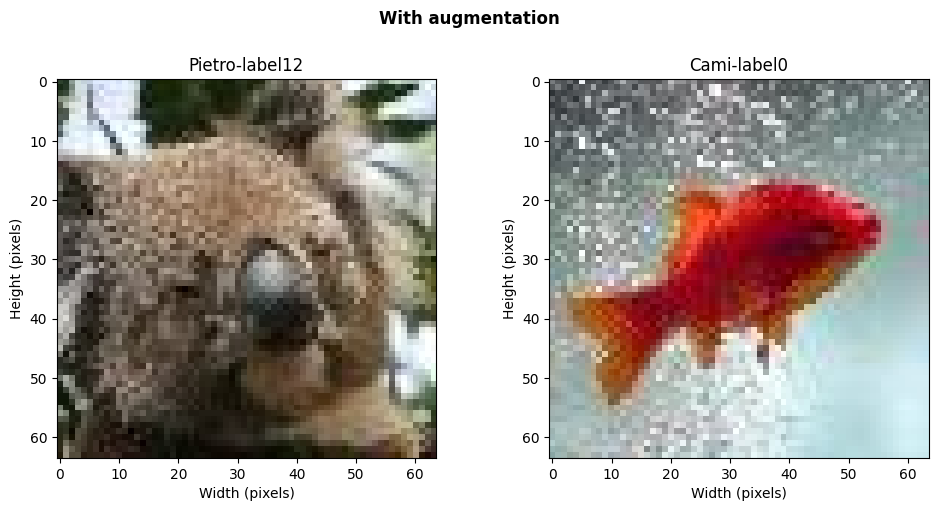

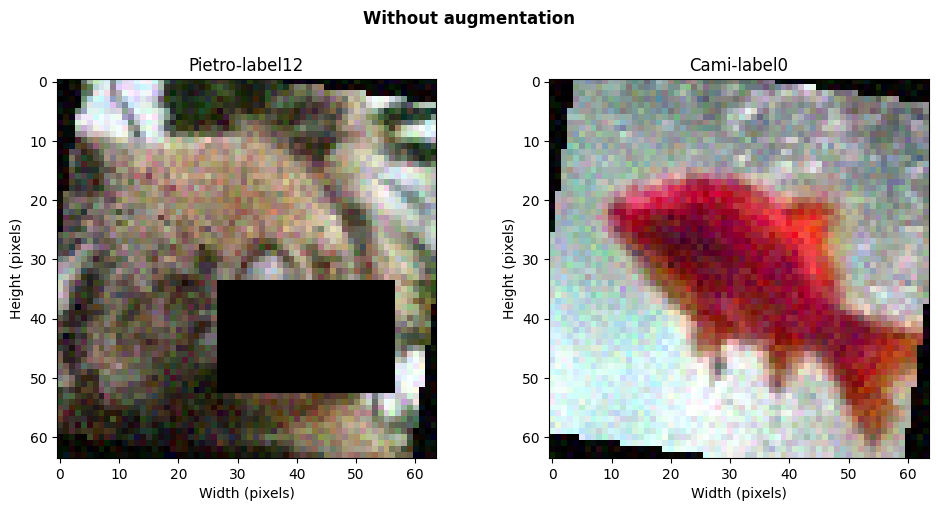

In [ ]:
mode = 'train'
datset_1 = DatasetLoader(data_path, mode, augmentation=False)
datset_2 = DatasetLoader(data_path, mode, augmentation=True)
#show_sample_1(datset_1, 'n01644900', 0, 'n01443537', 0)
show_sample_2(datset_1, mode, 'n01882714', 44, 'n01443537', 0,aug=True,denormalizing=True)
show_sample_2(datset_2, mode, 'n01882714', 44, 'n01443537', 0,aug=False,denormalizing=True)

#Network Functions


##Test Sasso

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               img_size,
               patch_size,
               channels,
               latent_size):
    super().__init__()
    #self.img_size = img_size
    self.patch_size = patch_size
    #self.channels = channels
    #self.latent_size = latent_size
    self.proj = nn.Conv2d(in_channels= channels,
                          out_channels= latent_size,
                          kernel_size= patch_size,
                          stride= patch_size)

    self.num_patches = (img_size // patch_size)**2

    self.cls_token = nn.Parameter(torch.randn(1, 1, latent_size)) #classification token to train
    self.pos_embed = nn.Parameter(torch.randn(1, (1+ self.num_patches), latent_size)) #positional embedding within image

  def forward(self, x: torch.Tensor):
    B = x.size(0)
    x = self.proj(x) #(B, E, H/P, W/P)
    x = x.flatten(2).transpose(1, 2) #(B, N, E)
    cls_token = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token,x), dim=1)
    x = x + self.pos_embed
    return x

In [ ]:
class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features= in_features,
                         out_features= hidden_features)
    self.fc2 = nn.Linear(in_features= hidden_features,
                         out_features= in_features)
    self.Dropout = nn.Dropout(p= drop_rate)

    self.ReLU = nn.ReLU()

  def forward(self, x):
    x = self.fc1(x)
    x = F.gelu(x)
    #x = self.ReLU(x)
    x = self.Dropout(x)
    x = self.fc2(x)
    x = self.Dropout(x)
    return x

In [ ]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0 or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # broadcast over batch
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        binary_tensor = torch.floor(random_tensor)
        return x / keep_prob * binary_tensor

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               latent_size,
               num_heads,
               mlp_dim,
               dropout,
               drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(latent_size)
    self.attn = nn.MultiheadAttention(latent_size, num_heads, dropout= dropout, batch_first= True)
    #self.drop_path1 = DropPath(drop_rate)
    self.norm2 = nn.LayerNorm(latent_size)
    self.mlp = MLP(latent_size, mlp_dim, dropout)
    #self.drop_path2 = DropPath(drop_rate)

  def forward(self, x):
    #x = x + self.drop_path1(self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0])
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    #x = x + self.drop_path2(self.mlp(self.norm2(x)))
    x = x + self.mlp(self.norm2(x))
    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self,
               img_size,
               batch_size,
               channels,
               num_classes,
               latent_size,
               encoders,
               num_heads,
               mlp_dim,
               dropout,
               drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size,
                                      patch_size,
                                      channels,
                                      latent_size)
    self.encoder = nn.Sequential(*[
        TransformerEncoder(latent_size, num_heads, mlp_dim, dropout, drop_rate)
        for _ in range(encoders)
        ])
    self.norm = nn.LayerNorm(latent_size)
    self.head = nn.Linear(latent_size, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    x = self.head(cls_token)
    return x

##Input Embedding

In [ ]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, latent_size=latent_size,
                batch_size=batch_size, device=device):
        super(InputEmbedding, self).__init__()
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.latent_size = latent_size
        self.batch_size = batch_size
        self.device = device

        self.input_size = self.patch_size*self.patch_size*self.n_channels
        self.LinearProjection = nn.Linear(self.input_size, self.latent_size) #Linear projection
        #self.class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device) #Class token
        #self.positional_embedding = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device) #Positional embedding
        self.class_token = nn.Parameter(torch.randn(1, 1, self.latent_size))
        self.positional_embedding = nn.Parameter(torch.randn(1, 4, self.latent_size))


    def forward(self, input):
        input = input.to(self.device)

        patches = einops.rearrange(
            input,
            #b=batch size, c=channels, h\w=number of patches on vertical\horizzontal axis, p1\p2=patch dimensions ---> (h p1)=h*p1 = height of the image
            'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
            p1=self.patch_size, p2=self.patch_size
            )

        #print(input.size())
        #print(patches.size())

        LinearProjection = self.LinearProjection(patches).to(self.device)
        batch, n_patches, _ = LinearProjection.shape
        class_token = self.class_token.expand(batch_size, -1, -1)  # share across batch
        LinearProjection = torch.cat((self.class_token, LinearProjection), dim=1)

        #controllare erpché tutti i token di ogni immagine hanno la stessa positional embedding!
        positional_embedding = einops.repeat(
            self.positional_embedding,
            'b 1 d -> b m d',
            m=n_patches+1
            )

        #print(LinearProjection.size())
        #print(positional_embedding.size())

        LinearProjection += positional_embedding
        return LinearProjection

##Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size=latent_size, n_heads=n_heads, dropout=dropout, device = device):
        super(Encoder, self).__init__()
        self.latent_size = latent_size
        self.n_heads = n_heads
        self.dropout = dropout
        self.device = device

        #norm layer
        self.norm_1 = nn.LayerNorm(self.latent_size)
        self.norm_2 = nn.LayerNorm(self.latent_size)

        #multihead atention
        self.multihead_attention = nn.MultiheadAttention(self.latent_size, self.n_heads, dropout=self.dropout)

        #add input
        #norm
        #MLP
        self.MLP = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4, self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):
        first_norm_out = self.norm_1(embedded_patches)
        attention_out = self.multihead_attention(first_norm_out, first_norm_out, first_norm_out)[0]

        first_add = attention_out + embedded_patches

        second_norm_out = self.norm_2(first_add)
        MLP_out = self.MLP(second_norm_out)

        out = MLP_out + first_add

        #print('embed: ', embedded_patches.size())
        #print('output', out.size())

        return out


##Transformer

(put everything together)

In [ ]:
class Vit(nn.Module):
    def __init__(self, n_encoders=n_encoders, latent_size=latent_size, n_classes=n_classes, dropout = dropout, device=device):
        super(Vit, self).__init__()
        self.n_encoders = n_encoders
        self.latent_size = latent_size
        self.n_classes = n_classes
        self.dropout = dropout
        self.device = device

        self.Embedding = InputEmbedding()

        self.EncoderStack = nn.ModuleList([Encoder() for i in range(self.n_encoders)])

        self.MLPHead = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.n_classes)
        )

    def forward(self, input):
        encoder_out = self.Embedding(input)

        for enc in self.EncoderStack:
            encoder_out = enc(encoder_out)

        cls_token = encoder_out[:, 0]
        MLPHead_out = self.MLPHead(cls_token)

        return MLPHead_out



##Test block

In [ ]:
#test_input = torch.randn(1,3,64,64)
#test_class = InputEmbedding(batch_size=1).to(device)
#test_class(test_input)
#test_encoder = Encoder().to(device)
#test_encoder(test_class(test_input))

#Pre-training


Create tuttecose

In [ ]:
#Transformer hyperparameters
#patch_size = 16
#latent_size = 768
#n_channels = 3
#n_heads = 12
#n_encoders = 12
#dropout = 0.1
#n_classes = 200 #According to tinyimagenet
#image_size = 64 #According to tinyimagenet

#Training
#epochs = 10
#batch_size = 4
#threshold = 10e-3
#weight_decay = 0.03
MLP_DIM = 512

In [ ]:
temp_batch_size = 128

train_dataset = DatasetLoader(data_path, 'train', augmentation=True)
validation_dataset = DatasetLoader(data_path, 'val', augmentation=False)
test_dataset = DatasetLoader(data_path, 'test', augmentation=False)

train_loader = DataLoader(train_dataset, batch_size=temp_batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=temp_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=temp_batch_size, shuffle=True)



In [ ]:
def apply_stochastic_depth(model, drop_prob):
    for module in model.modules():
        if isinstance(module, DropPath):
            module.drop_prob = drop_prob



#Training Phase


##Initializzation

In [ ]:
#model = Vit(n_encoders=n_encoders, latent_size=latent_size, n_classes=n_classes, dropout = dropout, device=device)


##--------- modello nuovo di prova
model_test = VisionTransformer(image_size,
                               temp_batch_size,
                               n_channels,
                               n_classes,
                               latent_size,
                               n_encoders,
                               n_heads,
                               MLP_DIM,
                               dropout,
                               0.1).to(device)

apply_stochastic_depth(model_test, drop_prob=0.1)
loss_val = nn.CrossEntropyLoss()
loss_train = SoftTargetCrossEntropy()
#loss_train = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

num_epochs=50

##aggiornato con model_test
'''
optimizer = torch.optim.Adam(model_test.parameters(), lr=learning_rate)
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model_test.parameters()),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=weight_decay
)
'''
optimizer = torch.optim.AdamW(
    model_test.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    betas=(0.9, 0.999)
)

mixup_fn = Mixup(
    #mixup_alpha=0.8,
    mixup_alpha=0.2,
    cutmix_alpha=1.0,
    cutmix_minmax=None,
    #prob=0.5,
    prob=0.2,
    #switch_prob=0.5,
    switch_prob=0.,
    label_smoothing=0.1,
    num_classes=n_classes
)
warmup = LinearLR(optimizer, start_factor=1e-3, total_iters=5)
cosine = CosineAnnealingLR(optimizer, T_max=num_epochs - 5)
#scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
scheduler = SequentialLR(optimizer, [warmup, cosine], milestones=[5])
scaler = torch.amp.GradScaler(device="cuda")

In [ ]:
#model_test.load_state_dict(torch.load("/home/user/work/Saved_Models/"))
#scheduler = SequentialLR(optimizer, [cosine], milestones=[5])

##Plot Gradient

In [ ]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu().detach().numpy())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.tight_layout()
    plt.pause(0.001)
    plt.close()



def plot_grad_flow_2(named_parameters, figsize=(12, 4), tick_step=5, log_scale=False):
    """
    Disegna il flow dei gradienti medi per layer.

    Args:
      named_parameters: modello.named_parameters()
      figsize: tupla per la dimensione della figura (larghezza, altezza)
      tick_step: mostra un’etichetta ogni `tick_step` parameteri
      log_scale: se True usa scala logaritmica in y
    """
    ave_grads = []
    layers = []
    for name, param in named_parameters:
        if param.requires_grad and "bias" not in name:
            layers.append(name)
            ave_grads.append(param.grad.abs().mean().cpu().item())

    fig, ax = plt.subplots(figsize=figsize)

    # Plot principale: linea con marcatori
    ax.plot(ave_grads, marker='o', linestyle='-', alpha=0.7)

    # Linea orizzonte a zero
    ax.axhline(0, color='black', linewidth=0.8)

    # Grid più leggera
    ax.grid(which='major', linestyle='--', alpha=0.5)
    ax.grid(which='minor', linestyle=':', alpha=0.3)

    # Scala log sui gradienti (opzionale)
    if log_scale:
        ax.set_yscale('log')

    # Limiti asse x
    ax.set_xlim(-0.5, len(ave_grads) - 0.5)

    # Etichette dei layer, mostro solo ogni tick_step
    ticks = np.arange(0, len(layers), tick_step)
    ax.set_xticks(ticks)
    ax.set_xticklabels([layers[i] for i in ticks], rotation=90, ha='right', fontsize=8)

    ax.set_xlabel("Layers")
    ax.set_ylabel("Average gradient" + (" (log scale)" if log_scale else ""))
    ax.set_title("Gradient flow")

    plt.tight_layout()
    plt.show()

def plot_grad_flow_3(
    named_parameters,
    epoch=None,
    batch_idx=None,
    figsize=(8, 12),
    tick_step=5,
    threshold=None,
    log_scale=False,

):
    """
    Disegna il flow dei gradienti medi per layer, con:
      - figura orizzontale (barh) per leggibilità
      - abbreviazione automatica dei nomi
      - tick ogni `tick_step` layer
      - colorazione rossa sotto soglia (se threshold non è None)
      - scala logaritmica (se log_scale=True)
      - annotazione del massimo gradiente

    Args:
      named_parameters: modello.named_parameters()
      figsize: (width, height) della figura
      tick_step: mostra una label ogni tick_step layer
      threshold: valore sotto il quale il bar è rosso (default blu)
      log_scale: attiva scala log su asse X
    """
    # 1) Raccogli nomi e gradienti medi
    layers, ave_grads = [], []
    for name, param in named_parameters:
        if param.requires_grad and "bias" not in name:
            # abbrevia nome togliendo prefissi/suffissi comuni
            short_name = name.replace("encoder.", "").replace(".weight", "")
            layers.append(short_name)
            ave_grads.append(param.grad.abs().mean().cpu().item())

    if not layers:
        print("Nessun parametro con gradiente da plottare.")
        return

    y = np.arange(len(layers))

    # 2) Setup figura
    fig, ax = plt.subplots(figsize=figsize)

    # 3) Colorazione in base alla soglia
    if threshold is not None:
        colors = ['r' if g < threshold else 'b' for g in ave_grads]
    else:
        colors = 'b'

    # 4) Bar plot orizzontale
    ax.barh(y, ave_grads, height=0.6, color=colors)
    ax.invert_yaxis()  # inverte per avere il primo layer in alto

    # 5) Scala logaritmica opzionale
    if log_scale:
        ax.set_xscale('log')

    # 6) Tick solo ogni `tick_step`
    ticks = y[::tick_step]
    ax.set_yticks(ticks)
    ax.set_yticklabels([layers[i] for i in ticks], fontsize=8)

    # 7) Annotazione del massimo gradiente
    '''
    imax = int(np.argmax(ave_grads))
    ax.text(
        ave_grads[imax],
        imax,
        f"{ave_grads[imax]:.2e}",
        va='center',
        ha='left',
        fontsize=7,
        color='darkgreen'
    )
    '''
    imax = np.argmax(ave_grads)  # Get the index of the max average gradient
    ax.annotate(
      f"{ave_grads[imax]:.2e}",
      xy=(ave_grads[imax], imax),
      xytext=(ave_grads[imax] + max(ave_grads)*0.05, imax),
      va='center',
      fontsize=10,
      fontweight='bold',
      color='darkgreen',
      arrowprops=dict(
          arrowstyle='-|>',
          color='darkgreen',
          lw=1.2
    ),
    bbox=dict(
        facecolor='white',
        edgecolor='darkgreen',
        boxstyle='round,pad=0.3',
        alpha=0.8
    )
    )


    # 8) Titoli e griglia
    ax.set_xlabel("Average gradient" + (" (log scale)" if log_scale else ""))
    ax.set_title(f"Gradient flow at epoch{epoch} - batch{batch_idx}")
    ax.grid(which='major', linestyle='--', alpha=0.5)

    '''
    if epoch is not None and batch_idx is not None:
            ax.text(
                0.01, 0.99,
                f"Epoch: {epoch}\nBatch: {batch_idx}",
                transform=ax.transAxes,
                va='top', ha='left',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
            )

    '''


    plt.tight_layout()

    #plt.show(block=False)
    #plt.pause(0.001)

    return fig



##Train Function

In [ ]:
bar_out  = Output()
plot_out = Output()
display(bar_out, plot_out)

def train(model, train_loader,optimizer, criterion, epoch,
          train_loss_list,acc_train_list,debug_mode=False ):

    #counter for total loss
    epoch_loss = 0.0
    model.train()

    predic_labels = []
    true_labels = []
    all_figs = []

    with bar_out:
        pbar = tqdm(train_loader, desc=f"Training epoch {epoch}", leave=True)

    '''
    pbar = tqdm(train_loader,
                desc=f"Training epoch {epoch}",
                leave=True,          # lascia la barra a fine ciclo
                dynamic_ncols=True)  # si adatta alla larghezza
    '''


    num_batch_to_display= random.randint(0, temp_batch_size)
    for idx,batch in enumerate(train_loader):

      ## gradients to 0 before working on a batch
      optimizer.zero_grad()
      inputs = batch['image']
      targets = batch['label']

      # Move inputs and targets to the correct device
      inputs = inputs.to(device)
      targets = targets.to(device)

      inputs, targets = mixup_fn(inputs, targets)

      with torch.amp.autocast("cuda"):
        output = model(inputs)
        output=output.to(device)
        #loss = criterion(output, targets.long())
        loss = criterion(output, targets)
      _,predicted=torch.max(output, dim=1)

      predic_labels.extend(predicted.cpu().tolist())
      #true_labels.extend(targets.cpu().tolist())#
      true_labels.extend(torch.argmax(targets, dim=1).cpu().tolist())

      if(debug_mode):


        print(f"Targets {targets}")
        print(f"Output {output}")
        print(f"output shape {output.shape}")
        print(f"targets shape {targets.shape}")
        print(f"predicted type {predicted.dtype} and shape {predicted.shape}")
        print(f"predic_labels current {predic_labels}")
        print(f"true_labels current {true_labels}")



        ############ First image of batch visualizing
      if(idx== num_batch_to_display):
        print(f"\n===================[Training Epoch{epoch}]...example image in  batch n°{num_batch_to_display}:\n")
        prova= inputs[0]
        prova= prova.cpu().permute(1, 2, 0).numpy()
        fig, ax = plt.subplots(1, 1, figsize=(5, 2))
        ax.imshow(prova)
        #ax.set_title(f"True label:{targets[0].cpu().item()}\nPreticted Label:{predicted[0].cpu().item()}")
        ax.set_title(f"True label:{torch.argmax(targets[0]).cpu().item()}\nPreticted Label:{predicted[0].cpu().item()}")
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        plt.pause(0.001)   # <--rendering forced
        plt.close()
        #######################

      ##backpropagation
      #loss.backward()
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      #optimizer.step()

      ##updating counter of total loss

      epoch_loss += loss.item()
      ##print("Plot of gradient style\n")
      #plot_grad_flow_2(model.named_parameters())

      with plot_out:
            clear_output(wait=True)

            figura=plot_grad_flow_3(
                model.named_parameters(),
                epoch=epoch,
                batch_idx=idx,
                figsize=(5, 8),    # se hai molti layer, allarga/altezza diversi
                tick_step=10,         # mostra 1 etichetta ogni 10 layer
                threshold=1e-5,       # colora in rosso gradienti troppo bassi
                log_scale=False
              # o True se vuoi scala log
            )
            if figura is not None:
                plt.show(figura)
                all_figs.append(figura)
                plt.close(figura)

      with bar_out:
            pbar.update(1)


    ########## the end of the for cycle of every batches





    acc = accuracy_score(true_labels, predic_labels)
    acc_train_list.append(acc)

    train_loss_list.append(epoch_loss)

    print(BLUE+f'\n#################### [Train epoch {epoch}]  || Loss {epoch_loss:.6f}  --> {epoch_loss:.3e}  || Accuracy {acc:.4f}-> ({acc*100.0:.4f})%\n'+RESET)

    if(debug_mode):
      for fig in all_figs:
        display(fig)




Output()

Output()

##Validation funciton

In [ ]:
def validate(model,val_loader,val_loss_list, optimizer,criterion, epoch, acc_list,debug_mode=False):

  #tolerance=1e-3
  model.eval()


  val_loss = 0.0

  predic_labels = []
  true_labels = []

  out_list=[]
  all_outputs = []
  all_targets = []

  # no computation of gradient and no backpropagation, not needed to update weights and optimizer

  with bar_out_val:
        pbar = tqdm(val_loader, desc=f"Validation epoch {epoch}", leave=True)

  with torch.no_grad():
    for batch in pbar:


      inputs = batch['image']
      inputs=inputs.to(device)
      targets=batch['label']
      targets = targets.to(device)

      output = model(inputs)
      loss = criterion(output, targets)
      _,predicted=torch.max(output, dim=1)
      predic_labels.extend(predicted.cpu().tolist())
      true_labels.extend(targets.cpu().tolist())


      '''
      copia_output=output.cpu().detach().numpy()
      copia_target=targets.cpu().detach().numpy()
      all_outputs.append(copia_output)
      all_targets.append(copia_target)
      '''

      ##aggiorno contatore val_loss

      val_loss += loss.item()

      '''
      #conversione delle probabilità di output in labels predette
      _ , predicted = torch.max(output, dim=1)
      predic_labels.extend(predicted.cpu())
      true_labels.extend(targets.cpu())
      out_list.extend(output.cpu())
      '''
      #corretti += torch.sum(torch.all(torch.abs(output - targets) < tolerance, dim=1)).item()

  # Stack outputs and target into a single array
  '''
  all_outputs = np.vstack(all_outputs)
  all_targets = np.vstack(all_targets)
  '''
  ##r2=r2_score(all_targets, all_outputs)

  #Results
  acc =  accuracy_score(true_labels, predic_labels)#corretti/len(val_dataset)
  acc_list.append(acc)
  val_loss_list.append(val_loss)


  print(BLUE+f'\n#################### [Val epoch {epoch}]  || Loss {val_loss:.6f}  --> {val_loss:.3e} || Accuracy {acc:.4f}-> ({acc*100.0:.4f})%\n'+RESET)


## Let's train the model

Output()

Output()

Output()


===================[Training Epoch0]...example image in  batch n°12:



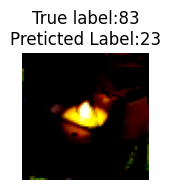


#################### [Train epoch 0]  || Loss 3560.947015  --> 3.561e+03  || Accuracy 0.0057-> (0.5726)%


#################### [Val epoch 0]  || Loss 425.875266  --> 4.259e+02 || Accuracy 0.0078-> (0.7800)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch1]...example image in  batch n°47:



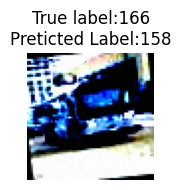


#################### [Train epoch 1]  || Loss 3383.387216  --> 3.383e+03  || Accuracy 0.0205-> (2.0464)%


#################### [Val epoch 1]  || Loss 389.530619  --> 3.895e+02 || Accuracy 0.0330-> (3.3000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch2]...example image in  batch n°98:



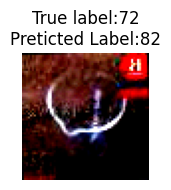


#################### [Train epoch 2]  || Loss 3300.344951  --> 3.300e+03  || Accuracy 0.0337-> (3.3690)%


#################### [Val epoch 2]  || Loss 375.379186  --> 3.754e+02 || Accuracy 0.0582-> (5.8200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch3]...example image in  batch n°25:



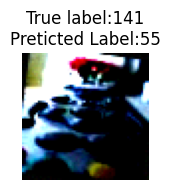


#################### [Train epoch 3]  || Loss 3210.964896  --> 3.211e+03  || Accuracy 0.0497-> (4.9679)%


#################### [Val epoch 3]  || Loss 358.187729  --> 3.582e+02 || Accuracy 0.0771-> (7.7100)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch4]...example image in  batch n°21:



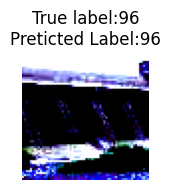


#################### [Train epoch 4]  || Loss 3123.570398  --> 3.124e+03  || Accuracy 0.0687-> (6.8726)%


#################### [Val epoch 4]  || Loss 342.759352  --> 3.428e+02 || Accuracy 0.1057-> (10.5700)%

Saving model..on Pietro pc


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model Saved in Pietro pc!

===================[Training Epoch5]...example image in  batch n°108:



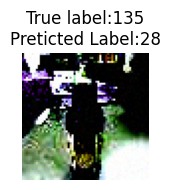


#################### [Train epoch 5]  || Loss 3061.770782  --> 3.062e+03  || Accuracy 0.0833-> (8.3286)%


#################### [Val epoch 5]  || Loss 335.765556  --> 3.358e+02 || Accuracy 0.1135-> (11.3500)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch6]...example image in  batch n°73:



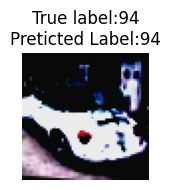


#################### [Train epoch 6]  || Loss 3005.504847  --> 3.006e+03  || Accuracy 0.0983-> (9.8321)%


#################### [Val epoch 6]  || Loss 328.531767  --> 3.285e+02 || Accuracy 0.1285-> (12.8500)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch7]...example image in  batch n°103:



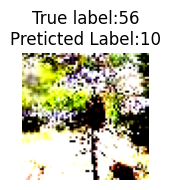


#################### [Train epoch 7]  || Loss 2958.567852  --> 2.959e+03  || Accuracy 0.1090-> (10.9024)%


#################### [Val epoch 7]  || Loss 322.894322  --> 3.229e+02 || Accuracy 0.1387-> (13.8700)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch8]...example image in  batch n°53:



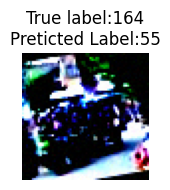


#################### [Train epoch 8]  || Loss 2911.274000  --> 2.911e+03  || Accuracy 0.1191-> (11.9119)%


#################### [Val epoch 8]  || Loss 317.881535  --> 3.179e+02 || Accuracy 0.1515-> (15.1500)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch9]...example image in  batch n°47:



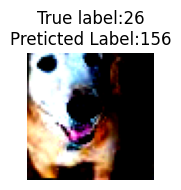


#################### [Train epoch 9]  || Loss 2875.053461  --> 2.875e+03  || Accuracy 0.1290-> (12.9000)%


#################### [Val epoch 9]  || Loss 313.356134  --> 3.134e+02 || Accuracy 0.1587-> (15.8700)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch10]...example image in  batch n°122:



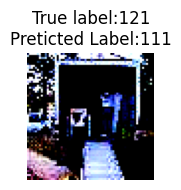


#################### [Train epoch 10]  || Loss 2843.505955  --> 2.844e+03  || Accuracy 0.1386-> (13.8619)%


#################### [Val epoch 10]  || Loss 310.996604  --> 3.110e+02 || Accuracy 0.1650-> (16.5000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch11]...example image in  batch n°81:



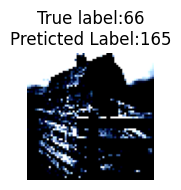


#################### [Train epoch 11]  || Loss 2813.506667  --> 2.814e+03  || Accuracy 0.1467-> (14.6690)%


#################### [Val epoch 11]  || Loss 306.939918  --> 3.069e+02 || Accuracy 0.1740-> (17.4000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!



===================[Training Epoch12]...example image in  batch n°66:



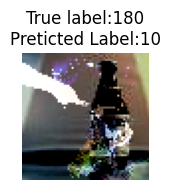


#################### [Train epoch 12]  || Loss 2772.398043  --> 2.772e+03  || Accuracy 0.1552-> (15.5155)%


#################### [Val epoch 12]  || Loss 303.584026  --> 3.036e+02 || Accuracy 0.1729-> (17.2900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch13]...example image in  batch n°55:



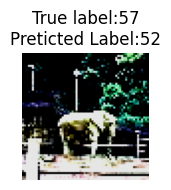


#################### [Train epoch 13]  || Loss 2741.227324  --> 2.741e+03  || Accuracy 0.1656-> (16.5607)%


#################### [Val epoch 13]  || Loss 300.504693  --> 3.005e+02 || Accuracy 0.1791-> (17.9100)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch14]...example image in  batch n°89:



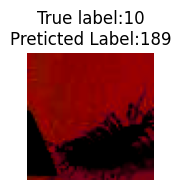


#################### [Train epoch 14]  || Loss 2704.541627  --> 2.705e+03  || Accuracy 0.1755-> (17.5524)%


#################### [Val epoch 14]  || Loss 299.590206  --> 2.996e+02 || Accuracy 0.1845-> (18.4500)%

Saving model..on Pietro pc
Model Saved in Pietro pc!



===================[Training Epoch15]...example image in  batch n°25:



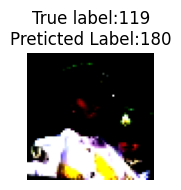


#################### [Train epoch 15]  || Loss 2669.758936  --> 2.670e+03  || Accuracy 0.1844-> (18.4357)%


#################### [Val epoch 15]  || Loss 297.635818  --> 2.976e+02 || Accuracy 0.1901-> (19.0100)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch16]...example image in  batch n°3:



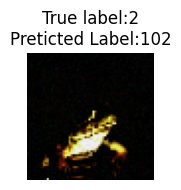


#################### [Train epoch 16]  || Loss 2631.473107  --> 2.631e+03  || Accuracy 0.1984-> (19.8405)%


#################### [Val epoch 16]  || Loss 294.600154  --> 2.946e+02 || Accuracy 0.1951-> (19.5100)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch17]...example image in  batch n°117:



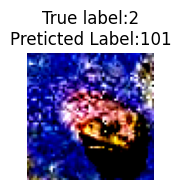


#################### [Train epoch 17]  || Loss 2599.708218  --> 2.600e+03  || Accuracy 0.2029-> (20.2869)%


#################### [Val epoch 17]  || Loss 291.920327  --> 2.919e+02 || Accuracy 0.2055-> (20.5500)%

Saving model..on Pietro pc
Model Saved in Pietro pc!



===================[Training Epoch18]...example image in  batch n°53:



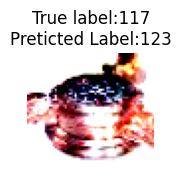


#################### [Train epoch 18]  || Loss 2570.176732  --> 2.570e+03  || Accuracy 0.2157-> (21.5702)%


#################### [Val epoch 18]  || Loss 291.519605  --> 2.915e+02 || Accuracy 0.2043-> (20.4300)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch19]...example image in  batch n°124:



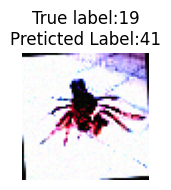


#################### [Train epoch 19]  || Loss 2524.135223  --> 2.524e+03  || Accuracy 0.2276-> (22.7631)%


#################### [Val epoch 19]  || Loss 289.950769  --> 2.900e+02 || Accuracy 0.2105-> (21.0500)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch20]...example image in  batch n°97:



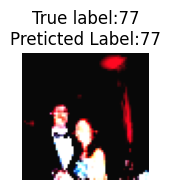


#################### [Train epoch 20]  || Loss 2487.026684  --> 2.487e+03  || Accuracy 0.2432-> (24.3214)%


#################### [Val epoch 20]  || Loss 288.808088  --> 2.888e+02 || Accuracy 0.2151-> (21.5100)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch21]...example image in  batch n°91:



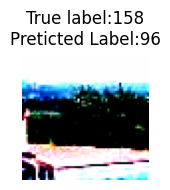


#################### [Train epoch 21]  || Loss 2449.871906  --> 2.450e+03  || Accuracy 0.2520-> (25.2024)%


#################### [Val epoch 21]  || Loss 286.325373  --> 2.863e+02 || Accuracy 0.2180-> (21.8000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch22]...example image in  batch n°87:



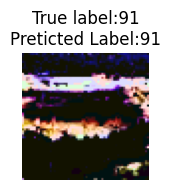


#################### [Train epoch 22]  || Loss 2411.824061  --> 2.412e+03  || Accuracy 0.2667-> (26.6750)%


#################### [Val epoch 22]  || Loss 287.643261  --> 2.876e+02 || Accuracy 0.2172-> (21.7200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch23]...example image in  batch n°101:



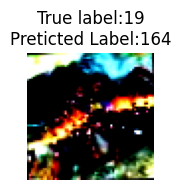


#################### [Train epoch 23]  || Loss 2374.241834  --> 2.374e+03  || Accuracy 0.2796-> (27.9571)%


#################### [Val epoch 23]  || Loss 285.968452  --> 2.860e+02 || Accuracy 0.2237-> (22.3700)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch24]...example image in  batch n°12:



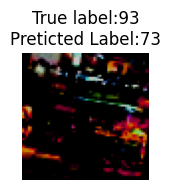


#################### [Train epoch 24]  || Loss 2333.546429  --> 2.334e+03  || Accuracy 0.2931-> (29.3143)%


#################### [Val epoch 24]  || Loss 284.978015  --> 2.850e+02 || Accuracy 0.2232-> (22.3200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch25]...example image in  batch n°82:



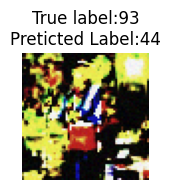


#################### [Train epoch 25]  || Loss 2297.224126  --> 2.297e+03  || Accuracy 0.3067-> (30.6690)%


#################### [Val epoch 25]  || Loss 284.902938  --> 2.849e+02 || Accuracy 0.2192-> (21.9200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch26]...example image in  batch n°98:



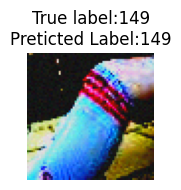


#################### [Train epoch 26]  || Loss 2240.934630  --> 2.241e+03  || Accuracy 0.3265-> (32.6524)%


#################### [Val epoch 26]  || Loss 284.829636  --> 2.848e+02 || Accuracy 0.2259-> (22.5900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch27]...example image in  batch n°4:



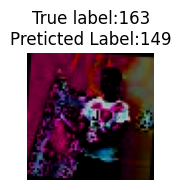


#################### [Train epoch 27]  || Loss 2212.027955  --> 2.212e+03  || Accuracy 0.3359-> (33.5857)%


#################### [Val epoch 27]  || Loss 285.696416  --> 2.857e+02 || Accuracy 0.2267-> (22.6700)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch28]...example image in  batch n°37:



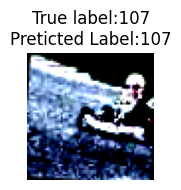


#################### [Train epoch 28]  || Loss 2169.566429  --> 2.170e+03  || Accuracy 0.3509-> (35.0940)%


#################### [Val epoch 28]  || Loss 285.787212  --> 2.858e+02 || Accuracy 0.2286-> (22.8600)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch29]...example image in  batch n°115:



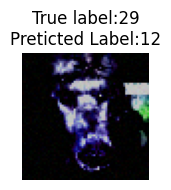


#################### [Train epoch 29]  || Loss 2153.399649  --> 2.153e+03  || Accuracy 0.3628-> (36.2833)%


#################### [Val epoch 29]  || Loss 286.020580  --> 2.860e+02 || Accuracy 0.2279-> (22.7900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch30]...example image in  batch n°20:



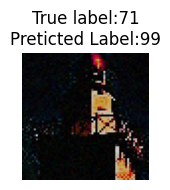


#################### [Train epoch 30]  || Loss 2096.743607  --> 2.097e+03  || Accuracy 0.3828-> (38.2821)%


#################### [Val epoch 30]  || Loss 286.315068  --> 2.863e+02 || Accuracy 0.2290-> (22.9000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!



===================[Training Epoch31]...example image in  batch n°48:



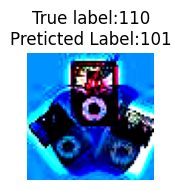


#################### [Train epoch 31]  || Loss 2073.250499  --> 2.073e+03  || Accuracy 0.3952-> (39.5226)%


#################### [Val epoch 31]  || Loss 285.877169  --> 2.859e+02 || Accuracy 0.2275-> (22.7500)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch32]...example image in  batch n°82:



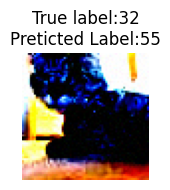


#################### [Train epoch 32]  || Loss 2040.580664  --> 2.041e+03  || Accuracy 0.4087-> (40.8702)%


#################### [Val epoch 32]  || Loss 286.825021  --> 2.868e+02 || Accuracy 0.2312-> (23.1200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch33]...example image in  batch n°10:



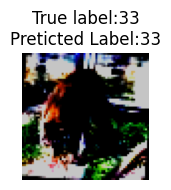


#################### [Train epoch 33]  || Loss 2000.921729  --> 2.001e+03  || Accuracy 0.4238-> (42.3786)%


#################### [Val epoch 33]  || Loss 287.842057  --> 2.878e+02 || Accuracy 0.2310-> (23.1000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!



===================[Training Epoch34]...example image in  batch n°116:



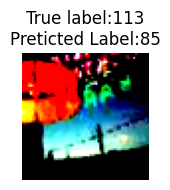


#################### [Train epoch 34]  || Loss 1956.939040  --> 1.957e+03  || Accuracy 0.4397-> (43.9702)%


#################### [Val epoch 34]  || Loss 289.081076  --> 2.891e+02 || Accuracy 0.2316-> (23.1600)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch35]...example image in  batch n°101:



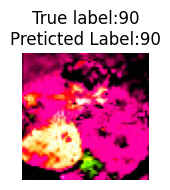


#################### [Train epoch 35]  || Loss 1924.104752  --> 1.924e+03  || Accuracy 0.4542-> (45.4250)%


#################### [Val epoch 35]  || Loss 288.634943  --> 2.886e+02 || Accuracy 0.2320-> (23.2000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch36]...example image in  batch n°42:



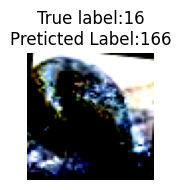


#################### [Train epoch 36]  || Loss 1906.553163  --> 1.907e+03  || Accuracy 0.4617-> (46.1726)%


#################### [Val epoch 36]  || Loss 288.217279  --> 2.882e+02 || Accuracy 0.2322-> (23.2200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch37]...example image in  batch n°78:



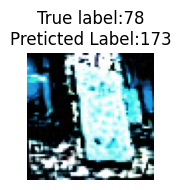


#################### [Train epoch 37]  || Loss 1881.575015  --> 1.882e+03  || Accuracy 0.4754-> (47.5381)%


#################### [Val epoch 37]  || Loss 289.836316  --> 2.898e+02 || Accuracy 0.2313-> (23.1300)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch38]...example image in  batch n°120:



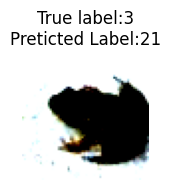


#################### [Train epoch 38]  || Loss 1840.906850  --> 1.841e+03  || Accuracy 0.4894-> (48.9369)%


#################### [Val epoch 38]  || Loss 290.064474  --> 2.901e+02 || Accuracy 0.2299-> (22.9900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch39]...example image in  batch n°57:



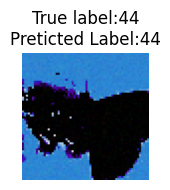


#################### [Train epoch 39]  || Loss 1846.013220  --> 1.846e+03  || Accuracy 0.4944-> (49.4440)%


#################### [Val epoch 39]  || Loss 290.210229  --> 2.902e+02 || Accuracy 0.2312-> (23.1200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch40]...example image in  batch n°64:



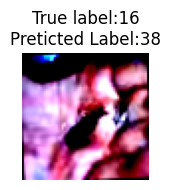


#################### [Train epoch 40]  || Loss 1818.591387  --> 1.819e+03  || Accuracy 0.5024-> (50.2393)%


#################### [Val epoch 40]  || Loss 290.177933  --> 2.902e+02 || Accuracy 0.2338-> (23.3800)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch41]...example image in  batch n°127:



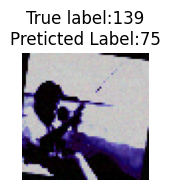


#################### [Train epoch 41]  || Loss 1783.726205  --> 1.784e+03  || Accuracy 0.5166-> (51.6607)%


#################### [Val epoch 41]  || Loss 290.265362  --> 2.903e+02 || Accuracy 0.2343-> (23.4300)%

Saving model..on Pietro pc
Model Saved in Pietro pc!



===================[Training Epoch42]...example image in  batch n°6:



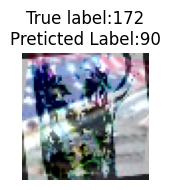


#################### [Train epoch 42]  || Loss 1784.285588  --> 1.784e+03  || Accuracy 0.5200-> (52.0048)%


#################### [Val epoch 42]  || Loss 290.640807  --> 2.906e+02 || Accuracy 0.2346-> (23.4600)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch43]...example image in  batch n°58:



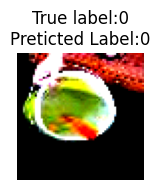


#################### [Train epoch 43]  || Loss 1775.104951  --> 1.775e+03  || Accuracy 0.5241-> (52.4143)%


#################### [Val epoch 43]  || Loss 290.142480  --> 2.901e+02 || Accuracy 0.2340-> (23.4000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch44]...example image in  batch n°121:



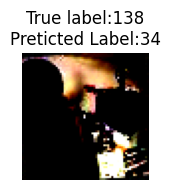


#################### [Train epoch 44]  || Loss 1786.149604  --> 1.786e+03  || Accuracy 0.5261-> (52.6060)%


#################### [Val epoch 44]  || Loss 290.981307  --> 2.910e+02 || Accuracy 0.2334-> (23.3400)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch45]...example image in  batch n°104:



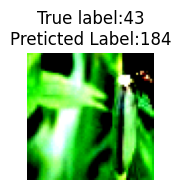


#################### [Train epoch 45]  || Loss 1750.157573  --> 1.750e+03  || Accuracy 0.5348-> (53.4821)%


#################### [Val epoch 45]  || Loss 291.581601  --> 2.916e+02 || Accuracy 0.2348-> (23.4800)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch46]...example image in  batch n°112:



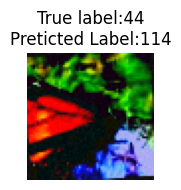


#################### [Train epoch 46]  || Loss 1734.740449  --> 1.735e+03  || Accuracy 0.5403-> (54.0250)%


#################### [Val epoch 46]  || Loss 290.387280  --> 2.904e+02 || Accuracy 0.2329-> (23.2900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch47]...example image in  batch n°73:



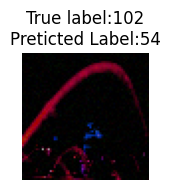


#################### [Train epoch 47]  || Loss 1750.029128  --> 1.750e+03  || Accuracy 0.5368-> (53.6845)%


#################### [Val epoch 47]  || Loss 291.727177  --> 2.917e+02 || Accuracy 0.2336-> (23.3600)%

Saving model..on Pietro pc
Model Saved in Pietro pc!



===================[Training Epoch48]...example image in  batch n°69:



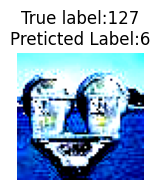


#################### [Train epoch 48]  || Loss 1738.487105  --> 1.738e+03  || Accuracy 0.5407-> (54.0690)%


#################### [Val epoch 48]  || Loss 291.135877  --> 2.911e+02 || Accuracy 0.2340-> (23.4000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!

===================[Training Epoch49]...example image in  batch n°95:



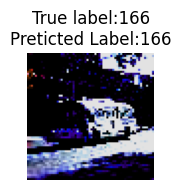


#################### [Train epoch 49]  || Loss 1712.477549  --> 1.712e+03  || Accuracy 0.5450-> (54.4952)%


#################### [Val epoch 49]  || Loss 291.355440  --> 2.914e+02 || Accuracy 0.2341-> (23.4100)%

Saving model..on Pietro pc
Model Saved in Pietro pc!
++++++++++Best epoch was 45 ++++++++++++++++++++

++++++++++Best val accuracy was 23.4800% ++++++++++++++++++++

++++++++++Best train accuracy was 54.4952% ++++++++++++++++++++

++++++++++Training time: 29256.79031229019 ++++++++++++++++++++



In [ ]:
## messo model_test per prova
model1 = model_test.to(device)

loss_train_list=[]
loss_val_list=[]
acc_train_list=[]
acc_val_list=[]
best_val_acc=0.0
best_epoch=0
best_train_acc=0.0

##num epochs spostato su initializzation

bar_out  = Output()
plot_out = Output()
bar_out_val  = Output()
display(bar_out,bar_out_val, plot_out)

#display(bar_out_val)
start_time = time.time()

version=1
pth_model = 'model'+str(version)+'_epochs'+str(num_epochs)+'.pth'
pth_optimizer='optimizer'+str(version)+'_epochs'+str(num_epochs)+'.pth'

for epoch in  range(num_epochs):

  train(model1, train_loader, optimizer, loss_train, epoch, loss_train_list, acc_train_list, debug_mode=False)
  validate(model1, validation_loader, loss_val_list, optimizer, loss_val, epoch, acc_val_list, debug_mode=False)
  scheduler.step()


  if(best_val_acc<acc_val_list[epoch]):
        ##print("Saving validation accuracy...\n")
        best_val_acc=acc_val_list[epoch]
        best_epoch=epoch
  if(best_train_acc<acc_train_list[epoch]):
        ##print("Saving training accuracy...\n")
        best_train_acc=acc_train_list[epoch]

  if device_name in device_list:
    print("Saving model..on Pietro pc")
    pth_checkpoint = 'model'+str(version)+'_epochs'+str(epoch)+'.pth'
    torch.save(model1.state_dict(), path_saves_pc_pi+pth_model)
    pth_optimizer_checkpoint='optimizer'+str(version)+'_epochs'+str(epoch)+'.pth'
    torch.save(optimizer.state_dict(), path_saves_pc_pi+pth_optimizer_checkpoint)
    print("Model Saved in Pietro pc!")



  '''
  <3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
  <3<3<3<3<3<3
  <3<3<3<3<3<3<3<3 LY <3<3<3<3<3<3<3<3
  '''

end=time.time()
print(RED+f"++++++++++Best epoch was {best_epoch} ++++++++++++++++++++\n")
print(RED+f"++++++++++Best val accuracy was {best_val_acc*100.0:.4f}% ++++++++++++++++++++\n")
print(RED+f"++++++++++Best train accuracy was {best_train_acc*100.0:.4f}% ++++++++++++++++++++\n")
print(RED+f"++++++++++Training time: {end-start_time} ++++++++++++++++++++\n")

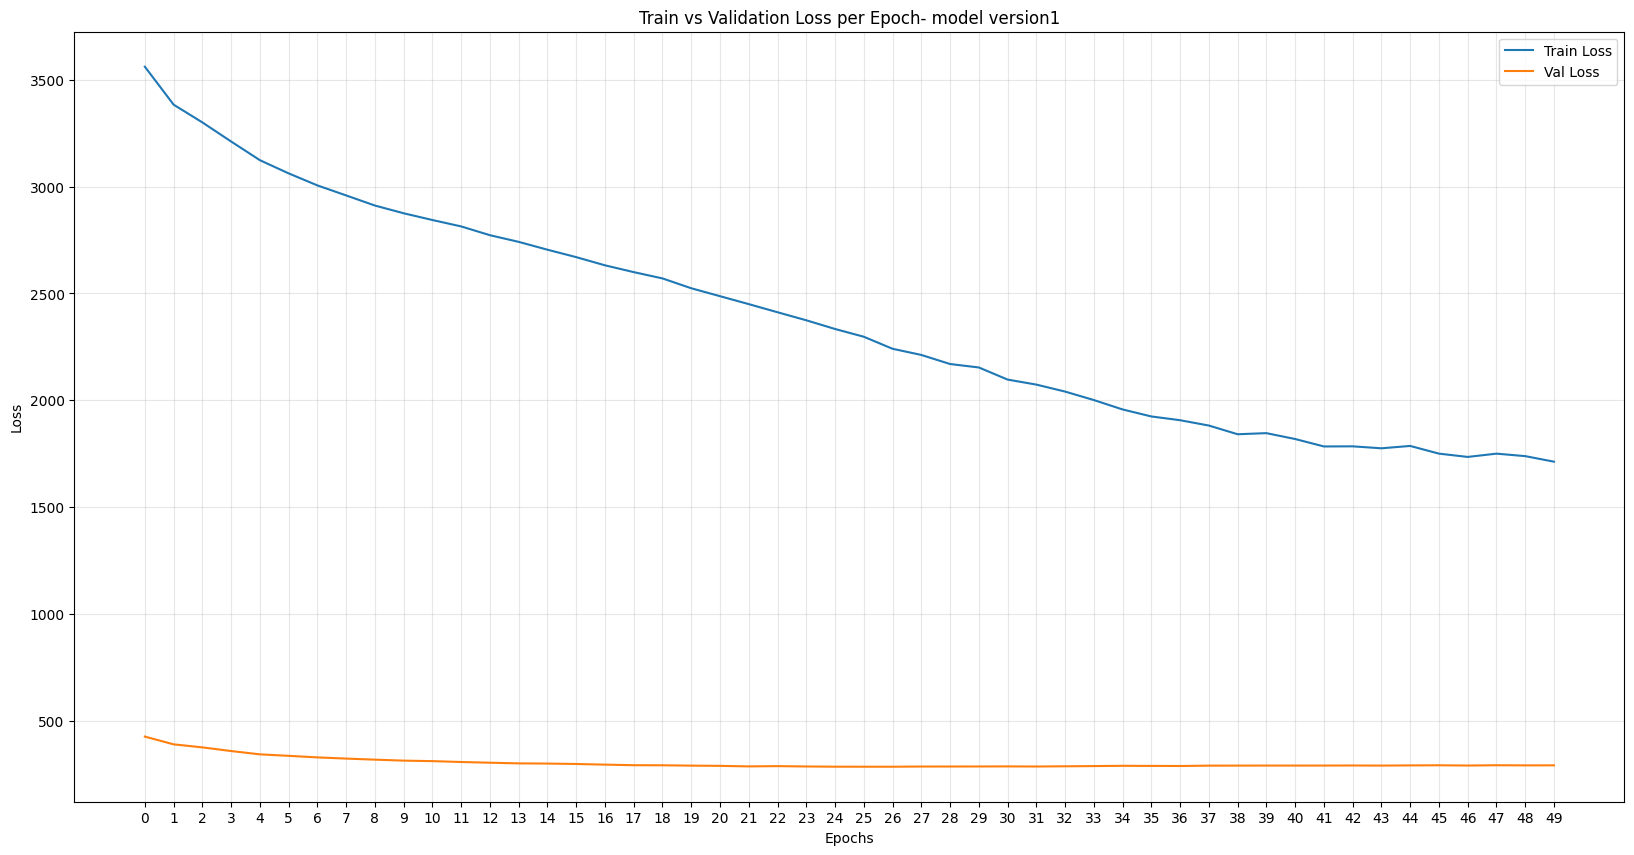

In [ ]:
#VisionTransformer_ 10.8% LR: 0.#Train and Validation Loss

list_epochs=list(range(0,len(loss_train_list)))
plt.figure(figsize=(20, 10))
plt.plot(loss_train_list, label="Train Loss")
plt.plot(loss_val_list, label="Val Loss")
plt.title(f"Train vs Validation Loss per Epoch- model version{version}")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(list_epochs)
plt.grid(linestyle='-',alpha=0.3)

plt.grid(linestyle='-',alpha=0.3)
plt.show()


In [ ]:
print(loss_train_list)
print(loss_val_list)

[3560.947014808655, 3383.387215614319, 3300.3449511528015, 3210.9648962020874, 3123.5703983306885, 3061.770782470703, 3005.504847049713, 2958.5678520202637, 2911.2740001678467, 2875.053460597992, 2843.5059547424316, 2813.5066673755646, 2772.398042678833, 2741.2273235321045, 2704.5416266918182, 2669.758935689926, 2631.473106622696, 2599.7082176208496, 2570.1767320632935, 2524.135223388672, 2487.0266835689545, 2449.871906042099, 2411.8240609169006, 2374.2418336868286, 2333.5464293956757, 2297.22412610054, 2240.9346301555634, 2212.0279552936554, 2169.5664286613464, 2153.399649143219, 2096.7436068058014, 2073.2504992485046, 2040.5806641578674, 2000.9217293262482, 1956.9390399456024, 1924.1047520637512, 1906.5531632900238, 1881.5750148296356, 1840.9068503379822, 1846.0132203102112, 1818.591387271881, 1783.7262046337128, 1784.2855880260468, 1775.1049511432648, 1786.1496040821075, 1750.1575727462769, 1734.7404491901398, 1750.0291283130646, 1738.4871051311493, 1712.4775485992432]
[425.87526559

###Saving current model

In [ ]:
if device_name not in device_list:
  print("Saving model..on drive")
  torch.save(model1.state_dict(),directory_saved_models_drive+pth_model)
  torch.save(optimizer.state_dict(), directory_saved_optimizers_drive+pth_optimizer)
  print("Model saved..on drive")


else:
  !pwd && ls -la
  if device_name in device_list:
    print("Saving model..on Pietro pc")
    torch.save(model1.state_dict(), path_saves_pc_pi+pth_model)
    torch.save(optimizer.state_dict(), path_saves_pc_pi+pth_optimizer)
    print("Model Saved in Pietro pc!")





/content
total 16
drwxr-xr-x 1 root root 4096 Jun  3 14:04 .
drwxr-xr-x 1 root root 4096 Jul  4 08:45 ..
drwxr-xr-x 4 root root 4096 Jun  3 14:04 .config
drwxr-xr-x 1 root root 4096 Jun  3 14:04 sample_data
Saving model..on Pietro pc
Model Saved in Pietro pc!


#Test Phase

## Test fuction

In [ ]:
def test(model,test_loader,criterion,debug_mode=False):

    model.eval()
    test_loss = 0.0


    predic_labels= []
    true_labels = []
    pbar = tqdm(test_loader, desc=f"Testing the model...",colour='red')

    all_outputs = []
    all_targets = []

    #no gradient computazion
    with torch.no_grad():
      i=0
      for batch in pbar:

        inputs = batch['image']
        targets = batch['label']

        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)

        loss = criterion(output, targets)
        test_loss += loss.item()
        '''

        copia_output=output.cpu().detach().numpy()
        copia_target=targets.cpu().detach().numpy()
        all_outputs.append(copia_output)
        all_targets.append(copia_target)

        '''

        _,predicted=torch.max(output, dim=1)
        predic_labels.extend(predicted.cpu().tolist())
        true_labels.extend(targets.cpu().tolist())



        i+=1

    # Stack outputs and target into a single array
    #all_outputs = np.vstack(all_outputs)
    #all_targets = np.vstack(all_targets)


    accuracy=accuracy_score(true_labels, predic_labels)

    print(CYAN+f'[Test] Loss : {test_loss:.6f}  --> {test_loss:.3e} || Accuracy {accuracy:.4f}-> ({accuracy*100.0:.4f})%\n'+RESET)

    #return predictions,true_values

In [ ]:
test(model=model_test,test_loader=test_loader,criterion=loss_val,debug_mode=True)

Testing the model...:   0%|          | 0/125 [00:00<?, ?it/s]

[Test] Loss : 460.152247  --> 4.602e+02 || Accuracy 0.2334-> (23.3438)%



#Final settings

In [16]:
fix_widgets_metadata(notebook_path)